In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from sklearn import datasets
import sklearn
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

2023-02-08 12:40:15.459408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import autograd.numpy as np
from autograd import elementwise_grad as grad

In [3]:
x = np.arange(6).astype(np.float32)
x

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [4]:
def f(x):
    return 3.0 * np.power(x, 2) + 5.0 * x - 4.0

In [5]:
grad_f = grad(f)

In [6]:
grad_f(x)

array([ 5., 11., 17., 23., 29., 35.], dtype=float32)

In [7]:
(f(x + 0.01) - f(x - 0.01)) / 0.02 # derivative: numerical computational definition of derivative: numerical differentiation

array([ 4.9999833, 11.000013 , 17.000008 , 22.999954 , 29.000473 ,
       35.001373 ], dtype=float32)

In [27]:
def linear(x):
  """Return linear function of itself."""
  return x

def d_linear(x):
    # differential of linear function
    return np.ones_like(x)


In [29]:
def relu(x):
  """Computes relu of function."""
  return x * (x >= 0)
def d_relu(x):
    # differential of relu 
    return (x >= 0).astype(np.float32)

In [31]:
def sigmoid(x):
  """Computes sigmoid of function."""
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    # differential of sigmoid function
    return sigmoid(x) * (1 - sigmoid(x))

In [32]:
activations = {
    "linear": linear,
    "relu": relu,
    "sigmoid": sigmoid
}

# differentiation
d_activations = {
    "linear": d_linear,
    "relu": d_relu,
    "sigmoid": d_sigmoid
}



In [36]:
def mse(y, p):
    """Computes Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, N) 
       p: predicted label of size (B, No)
     Returns:
       MSE of y-p
    """
    
    return np.mean((y - p)**2)

def d_mse(y, p):
    """Computes derivative of Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, N) 
       p: predicted label of size (B, No)
     Returns:
       derivaritve MSE of y-p
    """
   
    return 2*(p-y) / y.shape[0]



In [37]:
def d_binary_crossentropy(y, p, eps=1.e-17):
    """Computes binary crossentropy between y and p.
     Args:
       y: labeled data of size (B, No) 
       p: predicted label of size (B, No)
     Returns:

    """
    # add computation of binary crossentropy
    assert y.shape == p.shape
    return (- np.divide(y,p) + np.divide((1-y),(1-p))) / y.shape[0]

loss_function = {
    'mse': mse,
    'binary_crossentropy': binary_crossentropy
}

d_loss_function = {
    'mse': d_mse,
    'binary_crossentropy': d_binary_crossentropy
}

In [38]:
def binary_crossentropy(y, p):
    """Computes binary crossentropy between y and p.
     Args:
       y: labeled data of size (B, No) 
       p: predicted label of size (B, No)
     Returns:
       BCE of (y, p) = mean(sum(y log(p) + (1-y) log(1-p))) 
    """
    # add computation of binary crossentropy
    assert y.shape == p.shape
    return - np.mean(np.multiply(y, np.log(p)) + np.multiply((1-y), np.log(1-p)))

loss_function = {
    'mse': mse,
    'binary_crossentropy': binary_crossentropy
}

d_loss_function = {
    'mse': d_mse,
    'binary_crossentropy': d_binary_crossentropy
}



In [39]:
def initialize_weights(shapes, outputs):
    """Initializes weights of model according to shape.
     Args:
       shapes = [784, 300, 10] # input layer is 784, intermediate layer is 300 and output shape is 10. We have 2 layers: one layer converts input from 784 to 300 and a layer convert 300 to 10
       outputs = ["linear", "sigmoid"] # first layer is linear and 2nd layer is by sigmoid function
     returns:
       model with uniform random weights [-1,+1], zero bias and output function
       [
        [random(784, 300), zeros(300), "linear"]
        [random(300, 10), zeros(10), "sigmoid"] 
      ]
    """
    # do your code here
    results = []
    for i in range(1, len(shapes)):
        w = np.random.uniform(low=-1., high=1.0, size=(shapes[i-1], shapes[i]))
        b = np.zeros(shapes[i])
        results.append([w, b, outputs[i-1]])
    return results

# model = initialize_weights([4, 10, 3], ['sigmoid', 'sigmoid'])
# model
#[[w1, b1, 'sigmoid'], [w2, b2, 'sigmoid']]

In [40]:
def forward(x, model):
    """Performs forward pass of training step.

     Args:
       x: input tensor of shape (B, N0) # B: batch size
       model: list of model weights (see initialize weights)
     Returns:
       List containing dictionary { "y": y, "z": z } for each layer of network.
       [{"y": y1, "z": z1}, {"y": y2, "z": z2}]
    """
    result = []
    y = x
    for layer in model:
        # layer = [w[i], b[i], 'relu']
        z = np.dot(y, layer[0]) + layer[1]  # (B,N1) + (N1,N2)        
        y = activations[layer[2]](z)
        result.append({'y': y, 'z': z})

    return result

In [41]:
def predict(x, model):
    """Predicts the output of a model.

     Args:
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
     Returns:
       Prediction of model, with the same shape as the labeled data (B, No).
    """
    fwd = forward(x, model)
    return fwd[-1]["y"]

In [42]:
def backward(y, x, model, loss):
    """Computes backward step of training.
     Args:
       y: labeled data of size (B, No) 
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
       loss: one of ("mse", "binary_crossentropy")
     Returns:
       tuple with loss evaluation of (y, predict(x)) and list of dictionary
       containing { "dw": dw, "db": db } for each layer of network. Remember
       that shape of dw for each layer should be equal to shape of weight for
       the same layer.
       [{"dw": dw1, "db": db1}, {"dw": dw2, "db": db2}] # dw2 has same shape as w2 --> transpose
    """

    fwd_results = forward(x, model)  # 'y': activation(z), 'z': x * layer[0] + layer[1]
    loss_evaluation = loss_function[loss](y, fwd_results[-1]['y'])
    
    dy = grad(loss_function[loss], argnum=1)(y, fwd_results[-1]['y'])
    dz = np.multiply(dy, grad(activations[model[-1][2]])(fwd_results[-1]['z']))
    db = np.dot(dz.T, np.ones(fwd_results[-1]['y'].shape[0])) / x.shape[0]
    if len(fwd_results) > 1:
        dw = np.dot(dz.T, fwd_results[-2]['y']) / x.shape[0]
    else:
        dw = np.dot(dz.T, x) / x.shape[0]
        return [loss_evaluation, [{"dw": dw, "db": db}]]
    
    w = model[-1][0]
    
    result = [{"dw": dw, "db": db}]

    for layer in reversed(range(len(fwd_results)-1)):
        dy = np.dot(dz, w.T)
        dz = np.multiply(dy, grad(activations[model[layer][2]])(fwd_results[layer]['z']))
        if layer == 0:
            dw = np.dot(dz.T, x) / x.shape[0] 
        else:
            dw = np.dot(dz.T, fwd_results[layer-1]['y']) / x.shape[0] 
        db = np.dot(dz.T, np.ones(fwd_results[layer]['y'].shape[0])) / x.shape[0]
        w = model[layer][0]

        result.append({'dw': dw, 'db': db})
    
    result = result[::-1]

    return [loss_evaluation, result]

In [43]:
from sklearn.preprocessing import normalize

In [48]:
def load_data():
    (x_train, y_train), (x_test, y_test) = boston_housing.load_data()

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

    # condition data to be in a format you need to use
    x_scaler = MinMaxScaler((-1,1))
    y_scaler = MinMaxScaler((-1,1))

    x_train_scaled = x_scaler.fit_transform(x_train)
    y_train_scaled = y_scaler.fit_transform(y_train)

    x_test_scaled = x_scaler.fit_transform(x_test)
    y_test_scaled = y_scaler.fit_transform(y_test)

    return (x_train_scaled, y_train_scaled), (x_test_scaled, y_test_scaled)

In [49]:
def update(weights, dweights, alpha):
    """Gradient descent for weights and biases."""
    for i in range(len(weights)):
        weights[i][0] += - alpha * dweights[i]["dw"].T # layer 1
        weights[i][1] += - alpha * dweights[i]["db"].T # layer 2
    return weights

[13, 1]


/var/folders/lp/d6rvxqjj3kz6lttqxb7ll4080000gn/T/ipykernel_35503/2345541952.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, color='g')


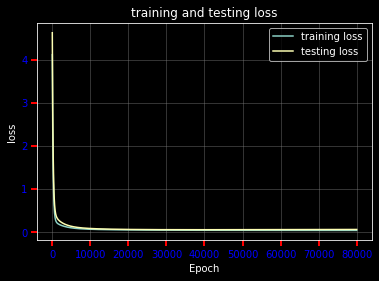

In [80]:
def train_network():

    (x_train, y_train), (x_test, y_test) = load_data()

    # linear network
    # plot training and test loss over time in jupyter notebook

    shapes = [x_train.shape[1], 1]

    print(shapes)

    outputs = ["linear"] # do linear regression
    model = initialize_weights(shapes, outputs) # single layer to test

    fwd_results = forward(x_train, model)

    # what's the alpha you should use?
    alpha = 0.3 
    train_loss = []
    test_loss = []
    
    for i in range(80000):
        loss, dweights = backward(y_train, x_train, model, "mse")
        model = update(model, dweights, alpha)

        train_loss.append(loss)
        y_predict = predict(x_test, model)
        test_loss.append(loss_function['mse'](y_test, y_predict))

    plt.plot(train_loss, label='training loss')
    plt.plot(test_loss, label='testing loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.style.use('dark_background')
    plt.grid(b=True, color='g')
    plt.legend()
    plt.title('training and testing loss')
    plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='b', colors='r', grid_color='gray', grid_alpha=0.5)
    plt.show()        

    return [train_loss, test_loss]
        
train_test_loss = train_network()

In [67]:
def load_iris():
    iris = datasets.load_iris()
    x = iris.data.astype(np.float32)
    
    y = iris.target

    y = to_categorical(y, np.max(y)+1).astype(np.float32)

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, random_state=42)
    # (B,) -> {0, 1, 2}
    # (B, 3) -> 0 -> y[:, 0] = 1, 1 -> y[:, 1] = 1

    # scale x_train, x_test
    x_scaler = MinMaxScaler((-1,1))
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.fit_transform(x_test) 
    
    return (x_train_scaled, y_train), (x_test_scaled, y_test)

def accuracy(y, p): # (B, 3)
    # y = (1, 0, 0), p = (0.2, 0.5, 0.3)
    # y = 0, p = 1
    return np.mean(np.argmax(y, axis=-1) == np.argmax(p, axis=-1))


In [68]:
from sklearn.model_selection import train_test_split

[4, 30, 10, 3]


/var/folders/lp/d6rvxqjj3kz6lttqxb7ll4080000gn/T/ipykernel_35503/1009045294.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, color='g')


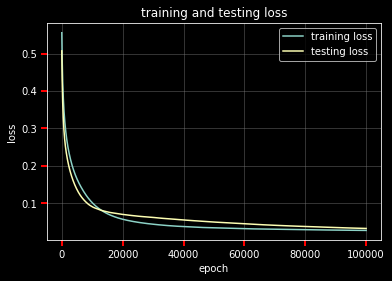

/var/folders/lp/d6rvxqjj3kz6lttqxb7ll4080000gn/T/ipykernel_35503/1009045294.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, color='g')


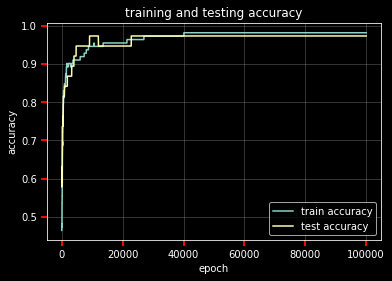

In [79]:
def train_network():
    (x_train, y_train), (x_test, y_test) = load_iris()

    outputs = ["relu", "relu", "sigmoid"] # network uses relu, relu, sigmoid
    shapes = [x_train.shape[1], 30, 10, y_train.shape[1]] # input shape, 30 layers, 10 layers, output shape: 3 classes

    print(shapes)

    # which alpha should you use?

    alpha = 0.3 # choose alpha
    model = initialize_weights(shapes, outputs)
    train_loss = []
    test_loss = []
    
    train_accuracy = []
    test_accuracy = []
    
    for i in range(100000):
        loss, dweights = backward(y_train, x_train, model, "binary_crossentropy")
        model = update(model, dweights, alpha)
        train_loss.append(loss)
        train_accuracy.append(accuracy(y_train, predict(x_train, model)))
        
        y_predict = predict(x_test, model)
        test_loss.append(loss_function['binary_crossentropy'](y_test, y_predict))
        test_accuracy.append(accuracy(y_test, y_predict))
        
    
    plt.plot(train_loss, label='training loss')
    plt.plot(test_loss, label='testing loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.style.use('dark_background')
    plt.grid(b=True, color='g')
    plt.title('training and testing loss')
    plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='w', colors='r', grid_color='gray', grid_alpha=0.5)
    plt.show()

    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(test_accuracy, label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.style.use('dark_background')
    plt.grid(b=True, color='g')
    plt.title('training and testing accuracy')
    plt.tick_params(axis='both', direction='out', length=6, width=2, labelcolor='w', colors='r', grid_color='gray', grid_alpha=0.5)
    plt.legend()
    plt.show()
    
train_network()